In [9]:
from distmesh import * 
import numpy as np 
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import diags
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({
        "font.family": "Times", 
        "text.usetex": True,
        "font.size": 16
    })

count =  200 displacement =  0.011957450025913786


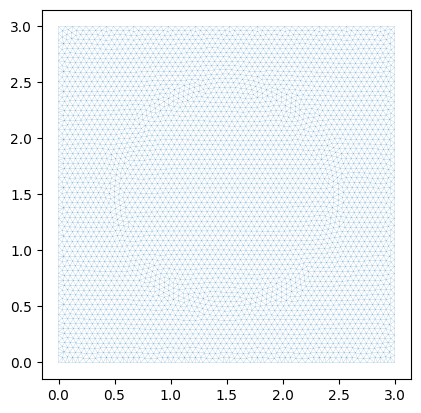

In [2]:
# generate mesh 
h = 0.05
pi = np.pi
def generate_circle(Npts):
    xc, yc = 1.5, 1.5
    return np.array([(np.cos((2*pi/Npts)*i)+xc, np.sin((2*pi/Npts)*i)+yc) for i in range(Npts)])
n = 50
x_fix = np.linspace(0, 3, n)
pfix = np.array([(0,x) for x in x_fix])
pfix = np.concatenate((pfix, [(x,0) for x in x_fix]))
pfix = np.concatenate((pfix, [(x,3) for x in x_fix]))
pfix = np.concatenate((pfix, [(3,x) for x in x_fix]))
pfix = np.concatenate((pfix, generate_circle(int(2*pi/h))))
bbox = np.array([0, 3, 0, 3])

def fd(p): 
    return drectangle(p, 0, 3, 0, 3)
pts, tri = distmesh2D(fd, huniform, h, bbox, pfix)

/var/folders/2x/bgd6yyyn4h71rbjgwy7c22tr0000gn/T/ipykernel_10241/838828581.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A = csr_matrix((Npts,Npts), dtype = np.float).toarray()
/var/folders/2x/bgd6yyyn4h71rbjgwy7c22tr0000gn/T/ipykernel_10241/838828581.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  B = csr_matrix((3,3),dtype =

Text(0.5, 1.0, 'FEM Numiercal Solution of Voltage ($a_2>a_1$)')

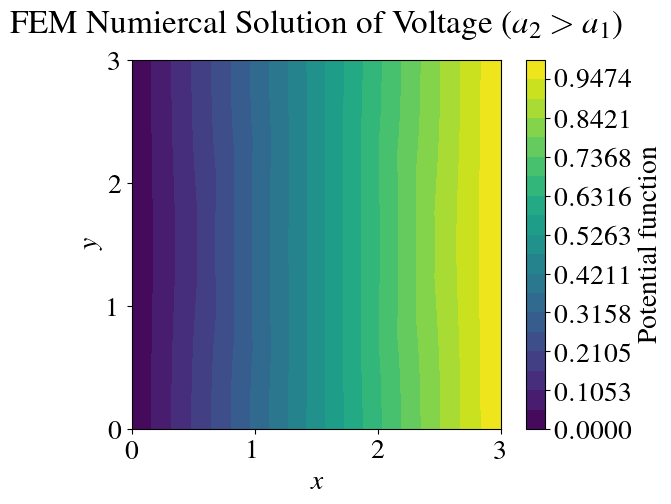

In [29]:

def a(mids, a1, a2):
    x = mids[:,0]
    y = mids[:,1]
    if (x-1.5)**2 + (y-1.5)**2 < 1: #inside circle
        return a1
    elif (x> 0 and y > 0) and (x < 3 and y < 3):
        return a2
    else: 
        return 0 
def stima3(verts):
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(verts)
    rhs = np.zeros((3,2))
    rhs[1,0] = 1
    rhs[2,1] = 1
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    M = 0.5*np.linalg.det(Aux)*np.matmul(G,np.transpose(G))
    return M

def FEM_committor_solver(pts,tri,Aind,Bind,a1,a2):
    Npts = np.size(pts,axis=0)
    Ntri = np.size(tri,axis=0)
    Dir_bdry = np.hstack((Aind,Bind))
    free_nodes = np.setdiff1d(np.arange(0,Npts,1),Dir_bdry,assume_unique=True)

    A = csr_matrix((Npts,Npts), dtype = np.float).toarray()
    b = np.zeros((Npts,1))
    q = np.zeros((Npts,1))
    q[Bind] = 1

    # stiffness matrix
    for j in range(Ntri):
        v = pts[tri[j,:],:] # vertices of mesh triangle
        vmid = np.reshape(np.sum(v,axis=0)/3,(1,2)) # midpoint of mesh triangle
        fac = a(vmid, a1, a2)
        ind = tri[j,:]
        indt = np.array(ind)[:,None]
        B = csr_matrix((3,3),dtype = np.float).toarray()
        A[indt,ind] = A[indt,ind] + stima3(v)*fac

    # load vector
    b = b - np.matmul(A,q)

    # solve for committor
    free_nodes_t = np.array(free_nodes)[:,None]
    q[free_nodes] = scipy.linalg.solve(A[free_nodes_t,free_nodes],b[free_nodes])
    q = np.reshape(q,(Npts,))
    return q



a1 = 0.8
a2 = 1
Aind = np.argwhere(pts[:,0] == 0) #d0 
NAind = np.size(Aind)
Aind = np.reshape(Aind, (NAind,))
Bind = np.argwhere(pts[:,0] == 3) #d1
NBind = np.size(Bind)
Bind = np.reshape(Bind, (NBind,))

q = FEM_committor_solver(pts, tri, Aind, Bind, a1, a2)

plt.tricontourf(pts[:,0], pts[:,1],tri,q,np.linspace(0,1,20))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("FEM Numiercal Solution of Voltage ($a_2>a_1$)",pad=20)


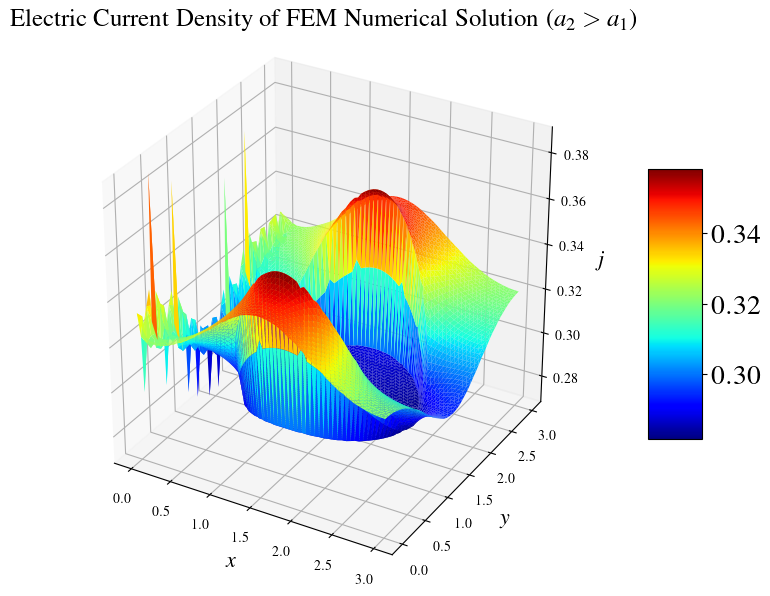

In [35]:
def grad(verts, utri):
    v = verts[1:3, 0] - verts[0, 0]
    w = verts[1:3, 1] - verts[0, 1]
    A = np.array([v, w]).T
    b = np.array([utri[1] - utri[0], utri[2] - utri[0]])
    return np.linalg.solve(A, b)

Npts = np.size(pts,axis=0)
Ntri = np.size(tri,axis=0)
current = np.zeros((Ntri, 2))
for j in range(Ntri):
    verts = pts[tri[j,:],:] 
    utri = q[tri[j,:]]
    g = grad(verts, utri)
    vmid = np.reshape(np.sum(verts,axis=0)/3,(1,2)) 
    aVal = a(vmid, a1, a2)
    current[j,:] = aVal*g
    

current_centers = np.sqrt(np.sum(current**2, axis=1))

current_verts = np.zeros(Npts)
count_tri = np.zeros(Npts)

for j in range(Ntri):
    current_verts[tri[j,:]] += current_centers[j]
    count_tri[tri[j,:]] += 1

current_verts[count_tri > 0] /= count_tri[count_tri > 0]

fig = plt.figure(figsize=(14,7))
ax = plt.axes(projection='3d')

surf = ax.plot_trisurf(pts[:,0], pts[:,1], current_verts, triangles=tri, cmap='jet', linewidth=0)

fig.colorbar(surf, shrink=0.5, aspect=5)
#ax.view_init(elev=90, azim=0)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16)
ax.set_zlabel('$j$', fontsize=16)
ax.set_title('Electric Current Density of FEM Numerical Solution ($a_2>a_1$)', fontsize=18)
ax.set_box_aspect([1, 1, 1])
plt.show()

